<a href="https://colab.research.google.com/github/Oleksij-gh/SentimentAnalysis/blob/main/NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Libs

In [22]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig

%matplotlib inline

# 2. Dataset

## Train

In [23]:
# Download data
!gdown 1HKqEIYP2KRpiXSkCOPFJ-5ugshxjdbmJ


# Unzip data
import zipfile
with zipfile.ZipFile('/content/archive.zip') as zip:
    zip.extractall('/content/data')




Downloading...
From: https://drive.google.com/uc?id=1HKqEIYP2KRpiXSkCOPFJ-5ugshxjdbmJ
To: /content/archive.zip
100% 2.09M/2.09M [00:00<00:00, 175MB/s]


In [24]:
import pandas as pd

In [25]:
data = pd.read_csv('/content/data/twitter_training.csv', names=['id', 'account_name', 'sentiment', 'text'])
data = data[[ 'text', 'sentiment']]
data.text.dropna()
data.head()

,text,sentiment
0,im getting on borderlands and i will murder yo...,Positive
1,I am coming to the borders and I will kill you...,Positive
2,im getting on borderlands and i will kill you ...,Positive
3,im coming on borderlands and i will murder you...,Positive
4,im getting on borderlands 2 and i will murder ...,Positive


<Axes: xlabel='sentiment'>

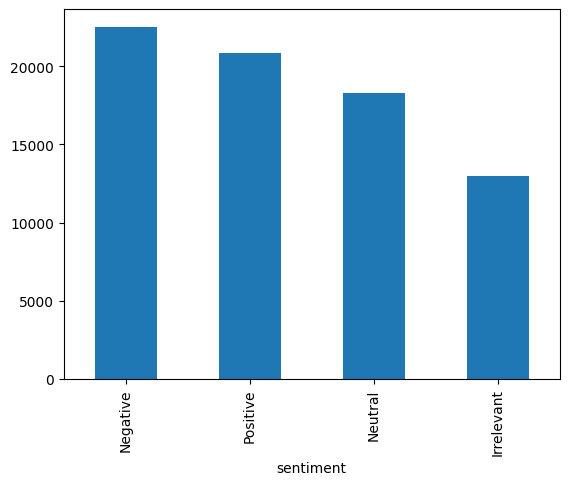

In [26]:
data['sentiment'].value_counts().plot(kind='bar')

In [27]:
data = data[(data['sentiment'] == 'Positive')  | (data['sentiment'] == 'Negative')]
data.loc[data['sentiment'] == 'Positive', 'sentiment'] = 1
data.loc[data['sentiment'] == 'Negative', 'sentiment'] = 0
data['sentiment'] = data['sentiment'].astype(np.float16)
data.head()

<ipython-input-27-7aaf7204d6ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['sentiment'] == 'Positive', 'sentiment'] = 1
<ipython-input-27-7aaf7204d6ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['sentiment'] == 'Negative', 'sentiment'] = 0
<ipython-input-27-7aaf7204d6ef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = d

,text,sentiment
0,im getting on borderlands and i will murder yo...,1.0
1,I am coming to the borders and I will kill you...,1.0
2,im getting on borderlands and i will kill you ...,1.0
3,im coming on borderlands and i will murder you...,1.0
4,im getting on borderlands 2 and i will murder ...,1.0


<Axes: xlabel='sentiment'>

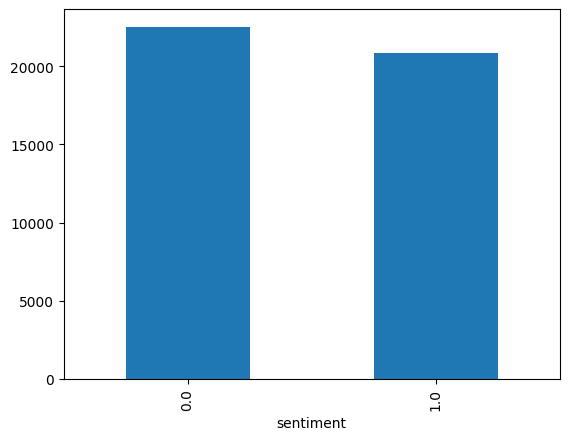

In [28]:
data['sentiment'].value_counts().plot(kind='bar')

In [29]:
from sklearn.model_selection import train_test_split

X = data.text.values
y = data.sentiment.values

#X = X[:len(X)//2]
#y = y[:len(y)//2]

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.2, random_state=7)

# 3

In [30]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# 4. Tokenize Bert

## 4.1 Bert tokenizer

In [31]:
def text_preprocessing(text):
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', str(text))

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', str(text)).strip()

    return text

In [32]:
# Load the BERT tokenizer

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment-latest', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [33]:
# Encode our data
#encoded_tweets = [tokenizer.encode(str(sent), add_special_tokens=True) for sent in data.text.to_numpy()]

# Find the maximum length
#max_len = max([len(sent) for sent in encoded_tweets])
#print('Max length: ', max_len)

In [34]:
#Tokenize our data.

# Specify `MAX_LEN`
MAX_LEN = 256

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  im getting on borderlands and i will murder you all ,
Token IDs:  [101, 10047, 2893, 2006, 3675, 8653, 1998, 1045, 2097, 4028, 2017, 2035, 1010, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


# 5. Fine-tune Bert

In [35]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train, dtype=torch.long)
val_labels = torch.tensor(y_val, dtype=torch.long)

batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [36]:
#defining new layers
class BERT_architecture(nn.Module):

    def __init__(self, bert):

      super(BERT_architecture, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.2)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [16]:
from transformers import AutoModel

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
#bert = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment-latest')

#freeze the pretrained layers
for param in bert.parameters():
    param.requires_grad = False

# pass the pre-trained BERT to our define architecture
model = BERT_architecture(bert)

# push the model to device
model = model.to(device)



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [17]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)  # learning rate


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [37]:
# define loss function
# add weights to handle the "imbalance" in the dataset
cross_entropy  = nn.CrossEntropyLoss()

# number of training epochs
epochs = 30

In [38]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step, batch in enumerate(tqdm(train_dataloader)):

    # progress update after every 50 batches.
    #if step % 50 == 0 and not step == 0:
      #print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [39]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(tqdm(val_dataloader)):

    # Progress update every 50 batches.
    #if step % 50 == 0 and not step == 0:

      # # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)

      # Report progress.
      #print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('\nTraining Loss: {}'.format(train_loss))
    print('Validation Loss: {}'.format(valid_loss))


 Epoch 1 / 30


  5%|▍         | 50/1085 [00:26<09:26,  1.83it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:52<08:22,  1.96it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:18<08:00,  1.95it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:44<07:45,  1.90it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:10<07:14,  1.92it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:36<06:48,  1.92it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:02<06:22,  1.92it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:28<05:57,  1.92it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:54<05:30,  1.92it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:20<05:04,  1.92it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:46<04:38,  1.92it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:12<04:11,  1.93it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:38<03:46,  1.92it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:04<03:20,  1.92it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:30<02:54,  1.92it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:56<02:28,  1.92it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:22<02:02,  1.92it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:48<01:36,  1.92it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:14<01:10,  1.92it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:40<00:44,  1.92it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:06<00:18,  1.92it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:24<00:00,  1.92it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:51,  1.99it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.98it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.98it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.98it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:06<00:11,  1.98it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  1.99it/s]



Training Loss: 0.5548854157671951
Validation Loss: 0.5318205944974633

 Epoch 2 / 30


  5%|▍         | 50/1085 [00:26<09:07,  1.89it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:52<08:28,  1.94it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:03,  1.93it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:41,  1.92it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:10<07:15,  1.92it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:36<06:48,  1.92it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:02<06:22,  1.92it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:28<05:56,  1.92it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:54<05:29,  1.93it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:20<05:04,  1.92it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:46<04:37,  1.93it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:12<04:11,  1.93it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:38<03:45,  1.93it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:04<03:20,  1.92it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:30<02:53,  1.93it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:56<02:28,  1.92it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:22<02:01,  1.93it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:48<01:36,  1.92it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:14<01:10,  1.92it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:40<00:44,  1.92it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:06<00:18,  1.92it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:23<00:00,  1.92it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:52,  1.98it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.98it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.98it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.98it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:06<00:11,  1.98it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  1.99it/s]



Training Loss: 0.5431666187701687
Validation Loss: 0.5251005997552591

 Epoch 3 / 30


  5%|▍         | 50/1085 [00:26<09:05,  1.90it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:52<08:29,  1.93it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:02,  1.94it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:39,  1.92it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:10<07:16,  1.91it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:36<06:49,  1.92it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:02<06:22,  1.92it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:28<05:56,  1.92it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:54<05:29,  1.93it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:20<05:04,  1.92it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:46<04:38,  1.92it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:12<04:12,  1.92it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:38<03:46,  1.92it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:04<03:20,  1.92it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:30<02:54,  1.92it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:56<02:28,  1.92it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:21<02:01,  1.93it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:47<01:35,  1.93it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:13<01:10,  1.93it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:39<00:44,  1.93it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:05<00:18,  1.93it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:23<00:00,  1.92it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:51,  1.99it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.98it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.99it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.98it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:06<00:11,  1.98it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  1.99it/s]



Training Loss: 0.5336884122015694
Validation Loss: 0.5128672124050996

 Epoch 4 / 30


  5%|▍         | 50/1085 [00:26<09:10,  1.88it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:52<08:28,  1.94it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:01,  1.94it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:39,  1.93it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:09<07:14,  1.92it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:36<06:49,  1.92it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:02<06:22,  1.92it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:28<05:56,  1.92it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:54<05:28,  1.93it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:19<05:03,  1.93it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:45<04:37,  1.93it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:11<04:11,  1.93it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:37<03:44,  1.94it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:03<03:18,  1.94it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:29<02:53,  1.93it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:55<02:27,  1.93it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:21<02:01,  1.93it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:47<01:35,  1.93it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:12<01:09,  1.93it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:38<00:44,  1.93it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:04<00:18,  1.92it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:22<00:00,  1.93it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:51,  1.99it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.99it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.99it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.98it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:05<00:11,  1.99it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  1.99it/s]



Training Loss: 0.526479561180563
Validation Loss: 0.5057392470976886

 Epoch 5 / 30


  5%|▍         | 50/1085 [00:25<09:05,  1.90it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:52<08:30,  1.93it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:04,  1.93it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:39,  1.93it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:09<07:15,  1.92it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:36<06:49,  1.92it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:02<06:22,  1.92it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:28<05:56,  1.92it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:54<05:30,  1.92it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:20<05:04,  1.92it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:46<04:38,  1.92it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:12<04:12,  1.92it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:38<03:46,  1.92it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:04<03:20,  1.92it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:30<02:54,  1.92it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:56<02:28,  1.92it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:22<02:02,  1.92it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:48<01:36,  1.92it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:14<01:10,  1.92it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:40<00:44,  1.92it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:06<00:18,  1.92it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:24<00:00,  1.92it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:51,  1.99it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:27,  1.97it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.99it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.98it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:06<00:11,  1.99it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  1.99it/s]



Training Loss: 0.5200240170900723
Validation Loss: 0.4985477965982521

 Epoch 6 / 30


  5%|▍         | 50/1085 [00:26<09:04,  1.90it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:52<08:29,  1.93it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:04,  1.93it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:37,  1.93it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:09<07:14,  1.92it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:35<06:48,  1.92it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:01<06:21,  1.93it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:27<05:54,  1.93it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:53<05:26,  1.94it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:19<05:02,  1.93it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:45<04:37,  1.93it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:11<04:11,  1.93it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:37<03:45,  1.92it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:03<03:20,  1.92it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:29<02:54,  1.92it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:55<02:27,  1.93it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:21<02:02,  1.91it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:47<01:36,  1.92it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:13<01:10,  1.92it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:39<00:44,  1.92it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:05<00:18,  1.92it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:23<00:00,  1.93it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:52,  1.98it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.98it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.99it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.98it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:05<00:11,  1.99it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  1.99it/s]



Training Loss: 0.5173380727592152
Validation Loss: 0.4959349563235746

 Epoch 7 / 30


  5%|▍         | 50/1085 [00:25<09:04,  1.90it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:52<08:29,  1.93it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:00,  1.95it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:42,  1.91it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:09<07:15,  1.92it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:35<06:47,  1.92it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:01<06:21,  1.92it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:27<05:56,  1.92it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:54<05:30,  1.92it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:20<05:03,  1.93it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:46<04:38,  1.92it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:12<04:12,  1.92it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:38<03:46,  1.92it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:04<03:20,  1.92it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:30<02:53,  1.93it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:56<02:28,  1.92it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:22<02:02,  1.92it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:48<01:35,  1.93it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:14<01:10,  1.92it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:40<00:43,  1.94it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:06<00:18,  1.94it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:23<00:00,  1.92it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:50,  2.00it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.99it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:00,  2.00it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.99it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:05<00:11,  1.99it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  2.00it/s]



Training Loss: 0.5114859574676109
Validation Loss: 0.4892549333984361

 Epoch 8 / 30


  5%|▍         | 50/1085 [00:25<09:04,  1.90it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:52<08:30,  1.93it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:04,  1.93it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:39,  1.93it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:09<07:15,  1.92it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:35<06:46,  1.93it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:01<06:19,  1.94it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:27<05:53,  1.94it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:53<05:29,  1.93it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:19<05:03,  1.93it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:45<04:37,  1.93it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:11<04:11,  1.93it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:37<03:45,  1.93it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:02<03:19,  1.93it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:28<02:54,  1.93it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:54<02:28,  1.92it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:20<02:02,  1.92it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:46<01:36,  1.93it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:12<01:10,  1.93it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:38<00:44,  1.93it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:04<00:18,  1.93it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:22<00:00,  1.93it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:51,  1.99it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.98it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.98it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.98it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:06<00:11,  1.98it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  1.99it/s]



Training Loss: 0.507521514656357
Validation Loss: 0.4852373752304736

 Epoch 9 / 30


  5%|▍         | 50/1085 [00:26<09:03,  1.91it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:52<08:30,  1.93it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:02,  1.94it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:40,  1.92it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:09<07:13,  1.93it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:35<06:48,  1.92it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:01<06:21,  1.93it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:27<05:54,  1.93it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:53<05:27,  1.94it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:19<05:01,  1.94it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:45<04:36,  1.93it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:11<04:11,  1.93it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:36<03:43,  1.95it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:02<03:19,  1.93it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:28<02:54,  1.92it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:54<02:28,  1.92it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:20<02:02,  1.92it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:46<01:36,  1.92it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:13<01:10,  1.92it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:39<00:44,  1.92it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:05<00:18,  1.92it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:23<00:00,  1.93it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:52,  1.98it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.99it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.99it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.99it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:05<00:11,  2.00it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  2.00it/s]



Training Loss: 0.5049307872073442
Validation Loss: 0.4887203955475022

 Epoch 10 / 30


  5%|▍         | 50/1085 [00:25<08:57,  1.93it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:51<08:33,  1.92it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:07,  1.92it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:40,  1.92it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:10<07:14,  1.92it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:36<06:48,  1.92it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:02<06:22,  1.92it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:28<05:56,  1.92it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:54<05:29,  1.92it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:20<05:04,  1.92it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:46<04:39,  1.92it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:12<04:12,  1.92it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:38<03:46,  1.92it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:04<03:20,  1.92it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:30<02:54,  1.92it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:56<02:28,  1.92it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:22<02:02,  1.92it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:48<01:36,  1.92it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:14<01:10,  1.92it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:40<00:44,  1.92it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:06<00:18,  1.92it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:24<00:00,  1.92it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:51,  1.99it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.99it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.99it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.99it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:05<00:11,  1.99it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  2.00it/s]



Training Loss: 0.5028825010297485
Validation Loss: 0.4853111710399389

 Epoch 11 / 30


  5%|▍         | 50/1085 [00:25<08:55,  1.93it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:51<08:29,  1.93it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:04,  1.93it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:39,  1.93it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:09<07:13,  1.92it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:35<06:48,  1.92it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:01<06:21,  1.93it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:27<05:55,  1.93it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:53<05:31,  1.92it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:19<05:04,  1.92it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:45<04:39,  1.92it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:11<04:12,  1.92it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:37<03:45,  1.93it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:03<03:19,  1.93it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:29<02:53,  1.93it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:55<02:27,  1.94it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:21<02:01,  1.93it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:47<01:36,  1.93it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:13<01:10,  1.93it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:39<00:44,  1.92it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:05<00:18,  1.91it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:23<00:00,  1.93it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:51,  1.98it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.99it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.98it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.99it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:05<00:11,  1.99it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  1.99it/s]



Training Loss: 0.5013505635722991
Validation Loss: 0.4802801293485305

 Epoch 12 / 30


  5%|▍         | 50/1085 [00:25<09:14,  1.87it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:52<08:35,  1.91it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:18<08:00,  1.95it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:40,  1.92it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:10<07:15,  1.92it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:35<06:44,  1.94it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:01<06:18,  1.94it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:27<05:54,  1.93it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:53<05:30,  1.92it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:19<05:05,  1.91it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:45<04:39,  1.91it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:11<04:12,  1.92it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:37<03:46,  1.92it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:03<03:19,  1.93it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:29<02:52,  1.94it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:55<02:27,  1.94it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:21<02:01,  1.93it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:47<01:35,  1.93it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:13<01:09,  1.93it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:39<00:44,  1.92it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:05<00:18,  1.92it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:22<00:00,  1.93it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:51,  1.98it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.99it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.98it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.99it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:05<00:10,  2.00it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  1.99it/s]



Training Loss: 0.49784985750501604
Validation Loss: 0.4799701421357253

 Epoch 13 / 30


  5%|▍         | 50/1085 [00:25<09:08,  1.89it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:52<08:29,  1.93it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:04,  1.93it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:39,  1.93it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:09<07:14,  1.92it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:35<06:48,  1.92it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:01<06:23,  1.92it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:28<05:56,  1.92it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:54<05:31,  1.91it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:20<05:04,  1.92it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:46<04:37,  1.93it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:12<04:11,  1.93it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:37<03:45,  1.93it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:03<03:19,  1.93it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:29<02:53,  1.93it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:55<02:27,  1.93it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:21<02:01,  1.93it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:47<01:36,  1.92it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:13<01:10,  1.92it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:39<00:44,  1.92it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:05<00:18,  1.92it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:23<00:00,  1.93it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:51,  1.98it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.99it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.99it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.99it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:05<00:11,  1.98it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  1.99it/s]



Training Loss: 0.4952049968978776
Validation Loss: 0.4724560997394078

 Epoch 14 / 30


  5%|▍         | 50/1085 [00:25<09:08,  1.89it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:52<08:29,  1.93it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:01,  1.94it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:40,  1.92it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:09<07:14,  1.92it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:35<06:47,  1.93it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:01<06:22,  1.92it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:27<05:55,  1.93it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:53<05:29,  1.93it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:19<05:04,  1.92it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:45<04:37,  1.93it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:11<04:11,  1.93it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:37<03:45,  1.93it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:03<03:19,  1.93it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:29<02:53,  1.93it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:55<02:27,  1.93it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:20<02:01,  1.94it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:46<01:35,  1.93it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:12<01:09,  1.93it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:38<00:44,  1.93it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:04<00:18,  1.93it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:22<00:00,  1.93it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:51,  1.99it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.99it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.99it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.99it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:05<00:11,  1.99it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  1.99it/s]



Training Loss: 0.4933134168523797
Validation Loss: 0.47047988500665217

 Epoch 15 / 30


  5%|▍         | 50/1085 [00:26<09:07,  1.89it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:52<08:30,  1.93it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:03,  1.94it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:41,  1.92it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:09<07:14,  1.92it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:35<06:47,  1.92it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:01<06:21,  1.93it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:27<05:55,  1.93it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:53<05:30,  1.92it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:19<05:03,  1.93it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:45<04:37,  1.93it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:11<04:11,  1.92it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:37<03:46,  1.92it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:03<03:20,  1.92it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:29<02:54,  1.92it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:55<02:28,  1.92it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:21<02:02,  1.92it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:47<01:36,  1.93it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:13<01:10,  1.93it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:39<00:44,  1.92it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:05<00:18,  1.92it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:23<00:00,  1.93it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:51,  1.98it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.98it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.98it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.98it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:06<00:11,  1.98it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  1.99it/s]



Training Loss: 0.4933021521788039
Validation Loss: 0.47302275572848673

 Epoch 16 / 30


  5%|▍         | 50/1085 [00:25<08:58,  1.92it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:51<08:29,  1.93it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:03,  1.93it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:37,  1.93it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:09<07:13,  1.93it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:35<06:48,  1.92it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:01<06:21,  1.93it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:27<05:56,  1.92it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:53<05:29,  1.93it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:19<05:04,  1.92it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:45<04:38,  1.92it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:11<04:11,  1.93it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:37<03:45,  1.93it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:03<03:19,  1.93it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:29<02:53,  1.93it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:55<02:27,  1.93it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:21<02:01,  1.93it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:46<01:35,  1.94it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:12<01:09,  1.94it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:38<00:44,  1.93it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:04<00:18,  1.94it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:22<00:00,  1.93it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:51,  1.99it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  2.00it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.99it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.99it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:05<00:11,  2.00it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:15<00:00,  2.00it/s]



Training Loss: 0.48878078793051055
Validation Loss: 0.46673625050222173

 Epoch 17 / 30


  5%|▍         | 50/1085 [00:26<09:22,  1.84it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:52<08:26,  1.94it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:18<07:57,  1.96it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:44<07:42,  1.92it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:10<07:15,  1.92it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:36<06:46,  1.93it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:01<06:20,  1.93it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:27<05:55,  1.93it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:53<05:27,  1.94it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:19<05:01,  1.94it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:45<04:35,  1.94it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:11<04:11,  1.93it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:37<03:45,  1.93it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:02<03:20,  1.92it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:29<02:54,  1.92it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:55<02:28,  1.92it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:21<02:02,  1.92it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:47<01:36,  1.92it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:13<01:10,  1.92it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:39<00:44,  1.92it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:05<00:18,  1.92it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:23<00:00,  1.93it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:51,  1.99it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.99it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.99it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  2.00it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:05<00:11,  1.99it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  1.99it/s]



Training Loss: 0.4862072137368989
Validation Loss: 0.4684730449362713

 Epoch 18 / 30


  5%|▍         | 50/1085 [00:25<08:57,  1.92it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:51<08:28,  1.94it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:04,  1.93it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:38,  1.93it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:09<07:12,  1.93it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:35<06:47,  1.93it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:01<06:19,  1.93it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:27<05:54,  1.93it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:52<05:26,  1.94it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:18<05:03,  1.93it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:44<04:37,  1.93it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:10<04:10,  1.93it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:36<03:45,  1.92it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:02<03:20,  1.92it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:28<02:54,  1.92it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:54<02:28,  1.92it/s]

  Batch   800  of  1,085.


 78%|███████▊  | 850/1085 [07:20<02:02,  1.93it/s]

  Batch   850  of  1,085.


 83%|████████▎ | 900/1085 [07:46<01:36,  1.92it/s]

  Batch   900  of  1,085.


 88%|████████▊ | 950/1085 [08:12<01:10,  1.92it/s]

  Batch   950  of  1,085.


 92%|█████████▏| 1000/1085 [08:38<00:44,  1.91it/s]

  Batch 1,000  of  1,085.


 97%|█████████▋| 1050/1085 [09:04<00:18,  1.92it/s]

  Batch 1,050  of  1,085.


100%|██████████| 1085/1085 [09:22<00:00,  1.93it/s]



Evaluating...


 18%|█▊        | 50/272 [00:25<01:51,  1.99it/s]

  Batch    50  of    272.


 37%|███▋      | 100/272 [00:50<01:26,  1.99it/s]

  Batch   100  of    272.


 55%|█████▌    | 150/272 [01:15<01:01,  1.99it/s]

  Batch   150  of    272.


 74%|███████▎  | 200/272 [01:40<00:36,  1.99it/s]

  Batch   200  of    272.


 92%|█████████▏| 250/272 [02:05<00:11,  1.99it/s]

  Batch   250  of    272.


100%|██████████| 272/272 [02:16<00:00,  2.00it/s]



Training Loss: 0.4884794890605909
Validation Loss: 0.4645866981762297

 Epoch 19 / 30


  5%|▍         | 50/1085 [00:26<09:14,  1.87it/s]

  Batch    50  of  1,085.


  9%|▉         | 100/1085 [00:52<08:27,  1.94it/s]

  Batch   100  of  1,085.


 14%|█▍        | 150/1085 [01:17<08:02,  1.94it/s]

  Batch   150  of  1,085.


 18%|█▊        | 200/1085 [01:43<07:41,  1.92it/s]

  Batch   200  of  1,085.


 23%|██▎       | 250/1085 [02:09<07:13,  1.92it/s]

  Batch   250  of  1,085.


 28%|██▊       | 300/1085 [02:35<06:47,  1.93it/s]

  Batch   300  of  1,085.


 32%|███▏      | 350/1085 [03:01<06:22,  1.92it/s]

  Batch   350  of  1,085.


 37%|███▋      | 400/1085 [03:27<05:55,  1.93it/s]

  Batch   400  of  1,085.


 41%|████▏     | 450/1085 [03:53<05:28,  1.93it/s]

  Batch   450  of  1,085.


 46%|████▌     | 500/1085 [04:19<05:04,  1.92it/s]

  Batch   500  of  1,085.


 51%|█████     | 550/1085 [04:45<04:38,  1.92it/s]

  Batch   550  of  1,085.


 55%|█████▌    | 600/1085 [05:11<04:11,  1.93it/s]

  Batch   600  of  1,085.


 60%|█████▉    | 650/1085 [05:37<03:46,  1.92it/s]

  Batch   650  of  1,085.


 65%|██████▍   | 700/1085 [06:03<03:20,  1.92it/s]

  Batch   700  of  1,085.


 69%|██████▉   | 750/1085 [06:29<02:55,  1.91it/s]

  Batch   750  of  1,085.


 74%|███████▎  | 800/1085 [06:55<02:28,  1.92it/s]

  Batch   800  of  1,085.


 75%|███████▍  | 812/1085 [07:01<02:22,  1.92it/s]

## 5.1 Train model

In [15]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 97.8 ms, sys: 7.98 ms, total: 106 ms
Wall time: 134 ms


## 5.2 Optimizer & Learning Rate Scheduler

In [16]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [17]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
set_seed(42)
# Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
